In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

## Background / Motivation

What motivated you to work on this problem?

Mention any background about the problem, if it is required to understand your analysis later on.

The Chicago Police Data Project is an intiative run by the Invisible Institute that tracks allegations of misconduct (complaints) filed against Chicago police officers, and whether those officers end up facing disciplinary action. Since 2000, there have been an average of roughly 7000 such complaints filed per year. Chicago police officers with 10+ complaints comprise as much as 22% of the entire police force. Only a tiny fraction of these compaints are sustained -- that is, deemed to have sufficient evidence to proceed with investigation -- and an even smaller fraction lead to actual disciplinary action. Understanding what factors are important in determing whether a complaint will ultimately lead to an officer being discplined is crucial for holding the Chicago Police Department accountable. 

## Problem statement 

The overall goal is to understand what factors determine whether a complaint is sustained and/or disciplined. We ask three questions (inference): 
1. What variables are most associated with whether an allegation of misconduct leads to an officer getting disciplined? 
2. What variables are most associated with whether an allegation of misconduct is sustained? 
3. Of the allegations of misconduct that are sustained, what variables are most associated with the disciplinary outcome?

Finally, we developed a logisitic regression model to predict the outcome of a complaint. Since so few officer's are disciplined, we think it is more important to catch all officers who "should" be discplined, then to avoid discplining officers who "shouldn't" be. We sought to maximize recall and minimize the false negative rate (FNR) all while achieving high accuracy. However, this is by no means the only way of approaching this problem. Focusing on precision, accuracy, or FPR would be equally valid but each have deeply ethical and moral implications that are outside the scope of data science, unless you are a data scientist who is also a philosopher (or AI alignment researcher).

## Data sources
[Chicago Police Data Project website](https://beta.cpdp.co/) 

[Data Repository](https://github.com/invinst/chicago-police-data)

## Stakeholders
Our stakeholders include: 
1. Chicago Police Department: They (ideally) want to understand what biases might exist in their review and discplinary process. 
2. Police watchdog organizations: Organizations that, for example, provide crucial information services to local communities, lobby congress, and otherwise do outreach activies. 
3. Criminal legal system: If our analyses reveal systemic bias in the compaint review and adjudication process, complaintants and victims can use this information to push their cases.  
4. Chicago residents: People living in Chicago have an interest in knowing what factors influence whether their complaints will lead to real action or not. Moreover, this sort of information is important for developing an informed citzenry. 
5. Criminologists and other sociologists
6. Citizens Police Data Project (CPDP): The organization that maintains the data repository.


## Data quality check / cleaning / preparation 

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

If the tables in this section take too much space, you may put them in the appendix, and just mention any useful insights you obtained from the data quality check that helped you develop the model or helped you realize the necessary data cleaning / preparation.

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? 

Did you do any data wrangling or data preparation before the data was ready to use for model development? Did you create any new predictors from exisiting predictors? For example, if you have number of transactions and spend in a credit card dataset, you may create spend per transaction for predicting if a customer pays their credit card bill. Mention the steps at a broad level, you may put minor details in the appendix. Only mention the steps that ended up being useful towards developing your final model(s).

In [61]:
raw_df = pd.read_csv('./project_data_unified/officers_only.csv')

#### 4 main categorical variables:

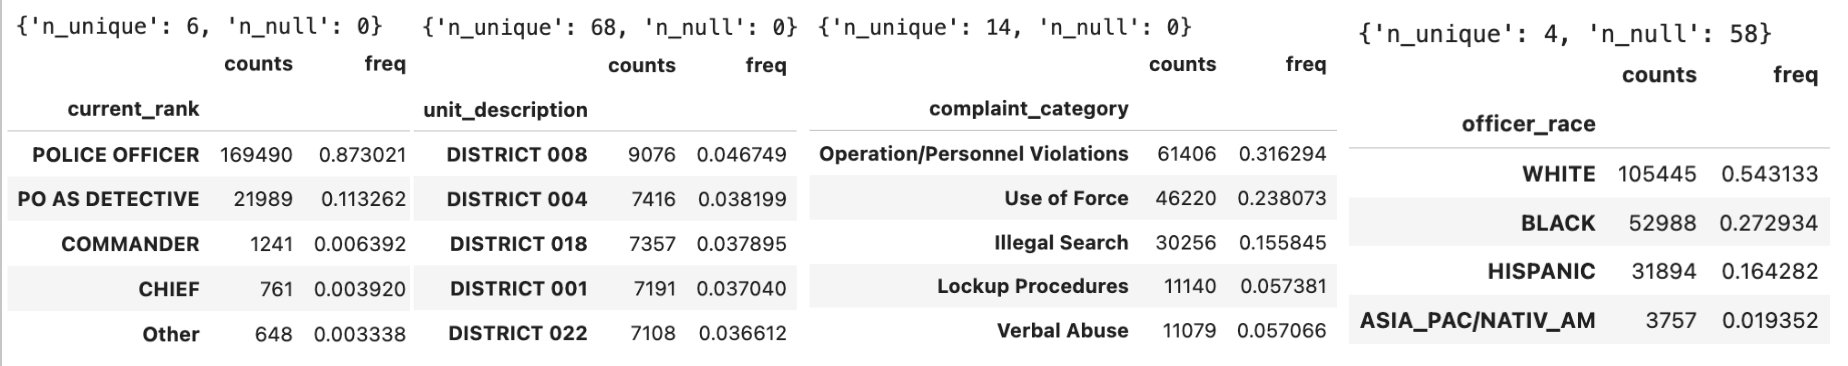

In [80]:
from IPython.display import Image
Image('./tabular_data.png')

The main and intial problem we faced was that the data did not come in one csv file, nor were the seperate csv files, containing different information on various officer/victim characteristics, formatted in the same way. Moreover, many of these files did not contain the same number of observations. This required us to first decide what subset of the data available we wanted to use, and second to clean that data considerably so that it was fit for logistic regresion analysis. We decided to focus on data pertaining primarily to the police officers themselves and the nature of their misconduct. The reason for this was twofold: (1) this was the data with smallest number of missing values; (2) it was the subset for which there were the most obsvations. For example, while including victim data is certainly possible, we opted not to because (i) only 1/3 of compaints had corresponding victim information and (ii) the victim data was highly incomplete (e.g. 70% missing race information etc.). 

From our data quality check we realize that: 

1. The data did not have a discpilined response column and so we had to construct it from the observations in "final_outcome". This meant we needed to decide which sorts of outcomes counted as discplined and which didn't. The Chicago Police Data Project and the Chicago Police Departments protocols mostly guided us here, with one exception, however. We decided not to consider "Reprimands" has a form of discipline, since it is more often used as a "token" punishment. But since reprimands represent the majority of formal disciplinary outcomes, this cut the number of disicplined complaints roughly in half (from 8.3% to 4.6%). 
2. The final_outcome column had double entries: once in lower case and once in upper case that needed to be combined. 
3. There were cateogries with very few (less than 0.01%) instances that needed to be either removed or consolidated. For example, we consolidated all gang related units in unit_description into one unit category. 

Please consult the accompanying code to see the further details about the cleaning process


## Exploratory data analysis

Put the relevant EDA here (visualizations, tables, etc.) that helped you figure out useful predictors for developing the model(s). Only put the EDA that ended up being useful towards developing your final model(s). 

List the insights (as bullet points) you got from EDA that ended up being useful towards developing your final model. 

Again, if there are too many plots / tables, you may put them into appendix, and just mention the insights you got from them.

In [10]:
df = pd.read_csv('./project_data_unified/cleaned_data.csv')

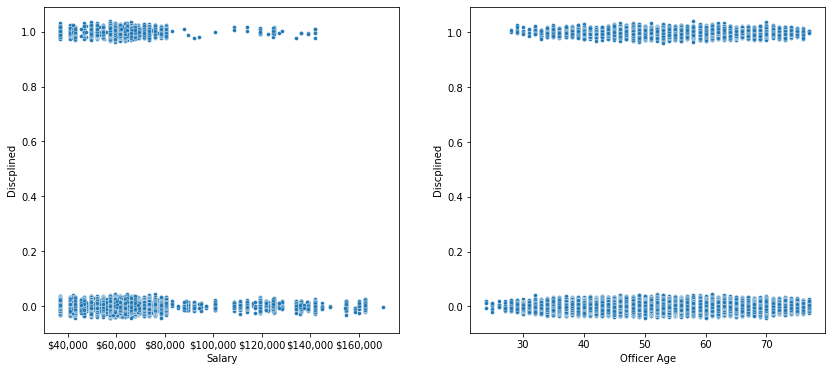

In [15]:
warnings.filterwarnings('ignore')
# Jitters points to make distribution more visible 
def jitter(values,j):
    return values + np.random.normal(j,0.01,values.shape)

# Plot response variable vs salary and officer age, see whether binning is needed
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)

ax=sns.scatterplot(df['salary'], jitter(df['y'],0), s=15, edgecolors='white', linewidths=0.2)
plt.xlabel('Salary')
plt.ylabel('Discplined')
ax.xaxis.set_major_formatter('${x:,.0f}')

plt.subplot(1, 2, 2)

ax=sns.scatterplot(df['officer_age'], jitter(df['y'],0), s=15, edgecolors='white', linewidths=0.2)
plt.xlabel('Officer Age')
plt.ylabel('Discplined')
plt.show()

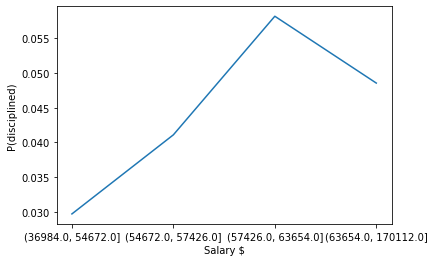

In [14]:
# Bin salary data

def var_transform(data):
    binned_salary = pd.qcut(data['salary'],4,retbins=True)
    bins = binned_salary[1]
    data['salary_binned'] = pd.cut(data['salary'],bins = bins)
    dum = pd.get_dummies(data.salary_binned,drop_first = True)
    dum.columns = ['salary'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

salary_bin_data=var_transform(df)

# Check whether probability of response changes non-monotonically across bins and whether bin number is appropriate
group_salary = salary_bin_data.groupby('salary_binned')['y'].agg([('p_disciplined','mean'),('nobs','count')]).reset_index(drop=False)

plt.plot(group_salary['salary_binned'].astype(str), group_salary['p_disciplined'])
plt.xlabel('Salary $')
plt.ylabel('P(disciplined)')
plt.show()

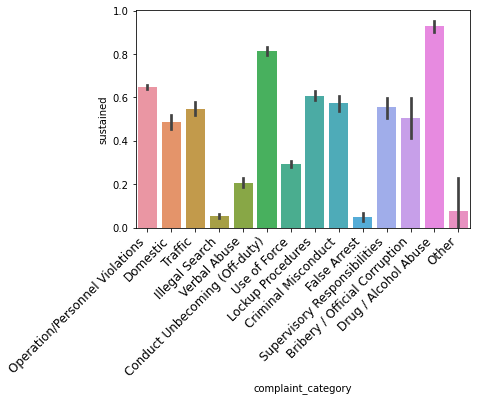

In [3]:
df = pd.read_csv('officers_only.csv', low_memory=False)

yes = df[df['sustained'] ==1]
no = df[df['sustained'] == 0].sample(yes.shape[0])
df = pd.concat([no, yes])

ax = sns.barplot(data=df, y='sustained', x='complaint_category')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12, horizontalalignment='right')
plt.show()

## Approach

What kind of a model (linear / logistic / other) did you use? What performance metric(s) did you optimize and why?

Is there anything unorthodox / new in your approach? 

What problems did you anticipate? What problems did you encounter? Did the very first model you tried work? 

Did your problem already have solution(s) (posted on Kaggle or elsewhere). If yes, then how did you build upon those solutions, what did you do differently? Is your model better as compared to those solutions in terms of prediction / inference?

**Important: Mention any code repositories (with citations) or other sources that you used, and specifically what changes you made to them for your project.**

In answering the first question, what variables are most associated with whether an allegation of misconduct leads to an officer getting disciplined, the overall goal was to find the largest number of the most significant predictors associated with the response. To this end, we took a slighly modifed backward selection approach. Starting with the full model of 96 predictors, the predictor with the largest p-value (most insignificant) was iteratively removed until no predictors had a p-value of greater than 0.05. The VIF of the resulting model's parameters indicated minimal multicollinearity issues: the largest VIF was less than 5, and most of the predictors had VIF close to 1. The VIF of all the predictors was computed before doing backward selection as well. However, the top multicollinear predictors, {race: WHITE}, {current_rank:POLICE_OFFICER}, and {current_rank: 'PO AS DETECTIVE'}, were the largest categories and therefore meaningful from an inference point of view. Removing all white police officers from the data would be unwise. Add to this the fact that backward selecting on p-values like we did will already filter out highly multicollinear predictors, we decided not to remove them before backward selecting the final model. Moreover, removing these two of these predictors and then back selecting led to almost exactly the same model. The model parameters were then further filtered based on an effect size criteria. We decided only to include those predictors that led to at least a 10% change in the odds of being discplined. This removed only one predictor, officer_age, however.

However, the inference model proved of limited effectiveness to the predictive power of the classification model. With a 95-5 data imbalance, the accuracy was artificially inflated with a massive trade off between recall and precision. Thus, we approached from the other way: forward selection. This was in part to see whether it would improve on the inference model, and also due to computational limitations. However, the predictive model had extremely limited effectiveness with a nearly full trade off of either near 100% recall or near 100% precision. Thus, the inference model was the more valuable model for delivering insights & utility to our shareholders.

Because this was a real world problem with real data, we had no idea if what we were attempting was possible. In hindsight, we should have set our aims lower: if there existed a highly precise or highly recall model to predict whether officer complaints--whether sustained or not--would lead to discipline, it would already have been implemented by the Chicago Police Department (we hope). However, the insights into the trade offs between Recall, Accuracy, and Precision as they relate to a highly imbalanced data set were extremely valuable.

## Developing the model

Explain the steps taken to develop and improve the base model - informative visualizations / addressing modeling assumption violations / variable transformation / interactions / outlier treatment / influential points treatment / addressing over-fitting / addressing multicollinearity / variable selection - stepwise regression, lasso, ridge regression). 

Did you succeed in achieving your goal, or did you fail? Why?

**Put the final model equation**.

**Important: This section should be rigorous and thorough. Present detailed information about decision you made, why you made them, and any evidence/experimentation to back them up.**

### Discipline Logistic Model

The raw data we found has proven to be next to useless in allowing us to create a decent precision, high recall model for predicting whether an accused officer will be disciplined. Thus, the Discipline Logistic Model has failed to achieve its goal.

One of the first improvements we made to the base model was fixing the imbalanced data (5% disciplined, 95% not disciplined). We did this by oversampling the disciplined data using SMOTE. We tried multiple ratios between 1:1 & 1:10, but it was clear that SMOTE would not be enough.

In addressing multicollinearity, we made sure to address VIF before we fed the data into SMOTE oversampling. We had to increase our threshold to 30, however, as the high number of variables was causing VIF to be very high. We also tried to remove the most collinear variables, and did this vastly improve our ability to run & fit the regression. However, the final results stuck with an unhelpful model that was either high recall or high precision, but never both.

We also tried to address overfitting by using a train-test split, but this did not help either. We adjusted the value from 0.2 to 0.5, but it did not help.

We used forward stepwise regression to select the variables minimized on AIC, as there were as many as 90 variables before preprocessing. This did, in limited test cases, improve the model. Mainly, it was shown to be effective in predicting whether officers who had their cases sustained would be disciplined. We chose AIC according to the campuswire post (https://campuswire.com/c/G13B6AABE/feed) We ultimately chose AIC because we simply did not have the quality of data to use BIC.

One of the biggest factors in our regression that affected recall & precision was selecting the threshold. We chose to maximize recall based on an arbitrary precision floor of 10%. As the base rate in the data set for disciplined officers is 95%, we wanted to at least double the base rate. When we graphed the precision-recall curve, we consistently saw Recall tank from around 80% to 20% within +/- 0.05 of 0.5. This worried us, because it continuously pointed to a data set that was not useful for predicting whether an officer would be disciplined. The precision, however, saw a much more steady increase in all our models, including ones with only sustained cases.

We used the following as a guide to build our threshold:
https://towardsdatascience.com/calculating-and-setting-thresholds-to-optimise-logistic-regression-performance-c77e6d112d7e

## Limitations of the model with regard to inference / prediction

If it is inference, will the inference hold for a certain period of time, for a certain subset of population, and / or for certain conditions.

If it is prediction, then will it be possible / convenient / expensive for the stakeholders to collect the data relating to the predictors in the model. Using your model, how soon will the stakeholder be able to predict the outcome before the outcome occurs. For example, if the model predicts the number of bikes people will rent in Evanston on a certain day, then how many days before that day will your model be able to make the prediction. This will depend on how soon the data that your model uses becomes available. If you are predicting election results, how many days / weeks / months / years before the election can you predict the results. 

When will your model become too obsolete to be useful?

One limitation of the model that we have built stems from the nature of the dataset underlying it. Because each row of the dataset represents a complaint against a given officer, the dataset doesn't provide information about the majority of officers who don't have complaints filed against them. In order to develop a model to determine the best predictors of whether any given officer is likely to be disciplined, one would want data detailing demographic and other information about all police officers, not just those who have committed an offense. Ultimately a model that predicts whether a police officer will be disciplined given that they have already committed an offense of some sort is not as powerful a tool as a model that predicts whether a police officer will be disciplined before they have the opportunity to commmit an offense.

## Findings from inference problems

The final, (p-value) back selected model had 42 parameters (please consult accompanying code for the full model output). 
The predictors that led to the largest increase in the odds of being discpilined were: 
1. Drug or alcohol abuse: 26.8x
2. Being part of a recruit training unit: 10.7x
3. Off duty conduct unbecoming: 6.9x
4. Bribery and Corruption: 6.8x 
5. Operation Personnel Violation*: 5.4x

The predictors that led to the largest decrease in the odds of being disciplined were: 
1. Illegal Search: 80.2% decrease
2. False arrest: 80% decrease 
3. Chief: 67.2%
3. Commander: 58.5%
4. White: 50% 

*includes such things as stealing items from the department

Some intereresting themes can be gleaned from the above results. (1) Officer that commit acts of misconduct that are not directly related to business of "policing" are the most likely to be discpilined. (2) Searching and arresting someone when they feel they shouldn't rarely ever leads to an officer being disciplined. There a few interpreations of this finding, we'll mention just two: (a) citizens are mistaken of what counts as illegal search or false arrest; (b) the police department doesn't want their officers to lose to ability to search and arrest people with impunity, as this is a core aspect of their operating model. (3) More senior and high ranking officers are the least likely to be discplined. Moreover, the units that experiences the largest increase in odds of disciplined are recruit training unit (i.e. units with the youngest, most inexperienced officers). (4) White officers are the least likely to be discplined, however, all races (white, Hispanic, Asian Pacific Islanders, and Native Americans) are all less likely to be disciplined than black officers. 

Inference #4 

Determining what the best predictors are for whether an officer will be disciplined for a given task using just the subset of data containing sustained complaints is an interesting task logically. As a reminder, sustained complaints are those for which there is enough evidence present to justing disciplinary action for the offending officer, but where that disciplinary action may or may not have been taken in reality. All of these complaints were large enough infractions to warrant significant repremand, but not all of these officers were punished, so there doesn't appear to that there is any concrete or established process underlying why so many sustained complaints go undisciplined. The predictors in do not seem to play a significant role into the Chicago Police Department's making of disciplinary decisions.

After creating a number of visualizations to being the exploratory data analysis process we found the variables within the final cleaned dataset that have the highest correlation with the target variable. As expected, use of force, unbecoming conduct off duty, domestic violence, and drug and alcohol abuse are all among the top 5 most highly correlated variables with the target. Suprisingly, the dummy variable corresponding to whether someone is Black or not is the 3rd highest correlated variable with our response (whether an officer is disciplined for an offense).

In order to infer what the most effective predictors are for determining whether an officer is disciplined or not using just the subset of data for sustained complaints, we developed a lasso regression model so that predictors with high variance would be shrunk to zero. This process resulted in the removal of not a significant amount of predictors, so we then removed remaining variables with a VIF over 5. Notable results from the result of this feature selection include that Male is the only general demographic characteristic surrounding an officers identity that remained after the variable selection. Interestingly also, the dummy corresponding to whether school admin or security was involved remained after the selection.

## Conclusions and Recommendations to stakeholder(s)

What conclusions do you draw based on your model? If it is inference you may draw conclusions based on the coefficients, statistical significance of predictors / interactions, etc. If it is prediction, you may draw conclusions based on prediction accuracy, or other performance metrics.

How do you use those conclusions to come up with meaningful recommendations for stakeholders? The recommendations must be action-items for stakeholders that they can directly implement without any further analysis. Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

If your recommendations are not practically implementable by stakeholders, how will they help them? Is there some additional data / analysis / domain expertise you need to do to make the recommendations implementable? 

Do the stakeholder(s) need to be aware about some limitations of your model? Is your model only good for one-time use, or is it possible to update your model at a certain frequency (based on recent data) to keep using it in the future? If it can be used in the future, then for how far into the future?

Recommendations pertaining to question 1's findings: 
1. Chicago Police Department: 
* Investigate why illegal search and false arrest accusations rarely ever lead to disciplinary outcomes. For example, perhaps this is due to a systemic bias in the review process.
* Identify potential issues with recruit training units (e.g. their structure, training protocol etc.) that might be causing them to commit punishable acts of misconduct. 
2. Police watchdog organizations:
* Research whether people do not understand what counts as an illegal search and false arrest. 
* Inform people that their accusations of false arrest and illegal search are unlikely to lead to discpilinary action. Perhaps its possible to improve the way these claims are argued so that this changes
3. Social scientists: 
* Investigate what it is about (the chicago) police department's culture that make it so intolerable of misconduct that happens off duty. 
* Investigate the time course of bribery and corruption allegations being discplined, since the Chicago police department has historically had big problems with corruption and has only recently begun a proactive compaign to root it out.

With regards to the prediction model:
The Citizens Police Data Project (the creators of this dataset) should add additional data to the dataset to investigate how we can predict whether an officer will be disciplined before they have the opportunity to commit an offense. This will require combining both the investigations mentioned data above as well as further data exploration. More data about districts such as income, crime rate, demographics, and more could help find more meaningful predictors.

## GitHub and individual contribution {-}

Put the **Github link** for the project repository.

Add details of each team member's contribution in the table below.

<html>
<style>
table, td, th {
  border: 1px solid black;
}

table {
  border-collapse: collapse;
  width: 100%;
}

th {
  text-align: left;
}
    

</style>
<body>

<h2>Individual contribution</h2>

<table style="width:100%">
     <colgroup>
       <col span="1" style="width: 15%;">
       <col span="1" style="width: 20%;">
       <col span="1" style="width: 50%;">
       <col span="1" style="width: 15%;"> 
    </colgroup>
  <tr>
    <th>Team member</th>
    <th>Contributed aspects</th>
    <th>Details</th>
    <th>Number of GitHub commits</th>
  </tr>
  <tr>
    <td>Elton John</td>
    <td>Data cleaning and EDA</td>
    <td>Cleaned data to impute missing values and developed visualizations to identify appropriate variable transformations.</td>
    <td>100</td>
  </tr>
  <tr>
    <td>Xena Valenzuela</td>
    <td>Assumptions and interactions</td>
    <td>Checked and addressed modeling assumptions and identified relevant variable interactions.</td>
    <td>120</td>
  </tr>
    <tr>
    <td>Sankaranarayanan Balasubramanian</td>
    <td>Outlier and influential points treatment</td>
    <td>Identified outliers/influential points and analayzed their effect on the model.</td>
    <td>130</td>    
  </tr>
    <tr>
    <td>Chun-Li</td>
    <td>Variable selection and addressing overfitting</td>
    <td>Performed variable selection on an exhaustive set of predictors to address multicollinearity and overfitting.</td>
    <td>150</td>    
  </tr>
</table>

List the **challenges** you faced when collaborating with the team on GitHub. Are you comfortable using GitHub? 
Do you feel GitHuB made collaboration easier? If not, then why? *(Individual team members can put their opinion separately, if different from the rest of the team)*

## References {-}

List and number all bibliographical references. When referenced in the text, enclose the citation number in square brackets, for example [1].

[1] Authors. The frobnicatable foo filter, 2014. Face and Gesture submission ID 324. Supplied as additional material
fg324.pdf. 3


## Appendix {-}

You may put additional stuff here as Appendix. You may refer to the Appendix in the main report to support your arguments. However, the appendix section is unlikely to be checked while grading, unless the grader deems it necessary.